# Spec2Vec - spectra networking
The aim of Spec2Vec is to represent each spectrum by an abstract, low-dimensional (typically 200-500 dimensional) vector which is able to capture the underlying molecular relationships between spectra.

One of the important envisioned use-cases for the Spec2Vec based spectra similarity measure, is **molecular networking**. Here we aim at clustering all spectra by building networks from nodes (=spectra) and their most prominent edges/connections (=most similar pairs of spectra).


## Notebook outline
1. Importing folders and packages
2. Import and filter MS-MS data from MGF file
3. Load model and find most similar spectra
4. Create network from modified cosine scores

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Locations (import paths from config.py)
from config import ROOT, PATH_SPEC2VEC, PATH_MS_DATA, PATH_SAVE_MODEL, PATH_COMPUTED, PATH_OUTPUT

sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic

# 1. Import and filter MS-MS data from MGF file

### Loading MGF file
In the following the MGF file containing all spectra and metadata will be loaded. 
The MGF file was generated from all publich gnps libraries (state: 26 July 2019). Spectra annotations were checked, cleaned, and extended where possible following a procedure described in another notebook: https://github.com/iomega/Spec2Vec/blob/master/notebooks/Spec2Vec_01_MGF_from_gnps_library_search.ipynb  

### Spectra filtering
#### 1. Discard spectra with too few peaks.
Spectra with less than "min_peaks" peaks will be ignored. Here this is set to min_peaks = 10.  

#### 2. Filter out noise. 
This can be done by:
#### A) Exponential peak intensity filter 
Further filtering is done to reduce the level of noise in the spectra. For this we calculate a threshold (or minimum peak intensity) for every spectrum. Where possible (most cases), this threshold is calculated by doing an exponential fit to the peak intensity histogram ("exp_intensity_filter"). If that fails we take the mean intensity of all peaks but the highest as a threshold.  
**But keep enough information:** Aimed at similar sized documents: If the number of peaks above the set threshold is lower than $n_{aim}$ = min_peaks + peaks_per_mz * precursor_mass we will at least keep the highest $n_{aim}$ peaks.

#### B) Relative peak intensity filter
This is a simpler filter which will discard all peaks with an intensity < min_intensity_perc/100 * max_peak_intensity.

### Creation of documents from spectra
Peaks and losses (= precursor mass - peak mass) are converted into words using a precision of "num_decimals".  
A peak with m/z = 108.3643 will hence become a string: "peak_108.36".  
A loss with m/z = 64.2257 will hence become a string: "loss_64.23".  
All words of one spectrum are collected in one list which represents the entire spectrum as a 'document'.

In [2]:
file_json = os.path.join(PATH_MS_DATA, "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json")
file_mgf = os.path.join(PATH_MS_DATA, "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra_uniqueInchikey_subset.mgf")

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0, #0.1,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [3]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


# 2. Load model and find most similar spectra

### Switch to Spec2Vec core functionality

In [4]:
# Import Spec2Vec functions
from similarity_measure import SimilarityMeasures
from plotting_functions import plot_precentile
import MS_similarity_classical as MS_sim_classic

# Import additional functions
from scipy import spatial

### Create SimilarityMeasures object

In [5]:
MS_library = SimilarityMeasures(MS_documents, MS_documents_intensity)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

Preprocess documents...
Number of unique words:  116344


### Load pretrained Spec2Vec model

In [6]:
file_model_word2vec = os.path.join(PATH_SAVE_MODEL, 'S2V_uniqueInchikey_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_iter100_TEMP_15.model')
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [15], 
                             use_stored_model=True)

Load stored word2vec model ...


In [7]:
MS_library.get_vectors_centroid(method = 'ignore', 
                                 tfidf_weighted = False, 
                                 weighting_power = 0.5, 
                                 tfidf_model = None,
                                 extra_epochs = 1)

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  10998  of  10998  documents. documents. of  10998  documents.10998  documents.10998  documents. 10998  documents. of  10998  documents. documents. documents. 5570  of  10998  documents. 10998  documents.  of  10998  documents. Calculated centroid vectors for  7330  of  10998  documents. 10998  documents. 7820  of  10998  documents. documents.  of  10998  documents. Calculated centroid vectors for  9000  of  10998  documents. 10998  documents. 10998  documents. documents.10998  documents.  documents.  of  10998  documents.

### Calculate similarities between all spectra and get top 25 for each spectrum

In [8]:
MS_library.get_centroid_similarity(num_hits=25, method='cosine')

Calculated distances between  10998  documents.


In [9]:
MS_library.list_similars_ctr_idx[0]

array([   0,  398, 1158,  383,  340,  343,  292,  650,  376,  352,  348,
       1933, 1930, 1931,   19,  285,  627,  581,  612,  379,  469, 1156,
        288,  322, 1932])

In [10]:
MS_library.list_similars_ctr[0]

array([1.        , 0.7166732 , 0.68961962, 0.68821332, 0.68798576,
       0.68034398, 0.67874722, 0.6663347 , 0.66539644, 0.66169041,
       0.66136296, 0.66124369, 0.64941635, 0.64821189, 0.64763228,
       0.63776666, 0.63374876, 0.62639644, 0.62429432, 0.62029123,
       0.61802026, 0.615745  , 0.61504999, 0.61463586, 0.61122527])

### Save MS_library object (including all computed S2V spectra vectors)

In [11]:
MS_library.save(PATH_COMPUTED + 'mol_networking_200206.obj')

### ... or load already built MS_library object:

In [ ]:
MS_library = SimilarityMeasures([])
MS_library.load(PATH_COMPUTED + 'unkown_spectra_search_191202.obj')

## Import reference matrix of all-vs-all molecular similarity values
Similarities based on molecular fingerprints. See other notebook on how those scores are derived:
**Spec2Vec_03_Similarities_based_on_molecular_fingerprints.ipynb**

In [12]:
filename = os.path.join(PATH_COMPUTED, 'MS_sim_mol_uniqueInchikey_rdkit2048_jaccard_191119.npy')
M_sim_mol = MS_sim_classic.mol_sim_matrix([],
                                       [],
                                       method = 'jaccard',
                                       filename = filename)

Molecular similarity scores found and loaded.


---

## Create and trim the network

### Import network functions

In [14]:
import networking as net
from networking import plot_clustering_performance, plots_cluster_evaluations
import networkx as nx

### Graph creation based on top max_links similarities
Add up to max_links links per node if those have similarities > cutoff.

In [14]:
MSnet = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.8,
                           link_method = 'single')

In [15]:
MSnet[10997]

AtlasView({4873: {'weight': 0.8130197878533513}, 5149: {'weight': 0.804400561065505}, 10996: {'weight': 0.9440537946305146}})

In [16]:
cluster_data = net.evaluate_clusters(MSnet,
                                     M_sim_mol)

In [17]:
cluster_data.head()

,num_nodes,num_edges,ref_sim_mean_edges,ref_sim_var_edges,ref_sim_mean_nodes,ref_sim_var_nodes
0,1,0,0.000000,0.000000,1.000000,0.000000
1,4212,16804,0.549537,0.085294,0.262253,0.020447
2,1,0,0.000000,0.000000,1.000000,0.000000
3,1,0,0.000000,0.000000,1.000000,0.000000
4,1,0,0.000000,0.000000,1.000000,0.000000


# 3. Create network from modified cosine scores

### Import all-vs-all matrix of modified cosine scores.
Derived in separate notebook:  
Spec2Vec_04_Similarities_based_on_classical_scores_on_uniqueInchikey_subset.ipynb

In [15]:
import MS_similarity_classical as MS_sim_classic

filename = os.path.join(PATH_COMPUTED, 'modcos_scores_191203_uniqueInchikey_pos_minperc05_tol0005.npy')
M_modcos_sim_greedy, M_modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                                                  tol = 0.005,
                                                  max_mz = 1000.0, 
                                                  min_intens = 0,
                                                  mass_shifting = True,
                                                  method='greedy-numba', 
                                                  num_workers = 4,
                                                  filename = filename,
                                                  safety_points = 25)

Complete cosine similarity scores found and loaded.


## Modified cosine score networking (basic setting)
### tol = 0.005, min_match = 1

In [16]:
M_modcos = M_modcos_sim_greedy.copy()

# Create numpy arrays to store top similarities for each spectrum
num_hits = 25
molnet_similars_idx = np.zeros((M_modcos.shape[0],num_hits), dtype=int)
molnet_similars = np.zeros((M_modcos.shape[0],num_hits))

for i in range(M_modcos.shape[0]):
    molnet_similars_idx[i,:] = M_modcos[i,:].argsort()[-num_hits:][::-1]
    molnet_similars[i,:] = M_modcos[i, molnet_similars_idx[i,:]]

In [20]:
MSnets_modcos = []
DATA_modcos = []
DATA_modcos_louvain = []
thresholds = [0.6, 0.7, 0.8, 0.9, 0.95]

# Create network for different cutoff thresholds:
for thres in thresholds:
    MSnets_modcos.append(net.create_network(molnet_similars_idx,
                                           molnet_similars,
                                           max_links = 10,
                                           cutoff = thres,
                                           link_method = 'single'))
    
for network in MSnets_modcos:
    cluster_data = net.evaluate_clusters(network,
                                     M_sim_mol)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network,
                                                     M_sim_mol,
                                                     resolution = 1.0)
    
    DATA_modcos.append(cluster_data)
    DATA_modcos_louvain.append(cluster_data_louvain)

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


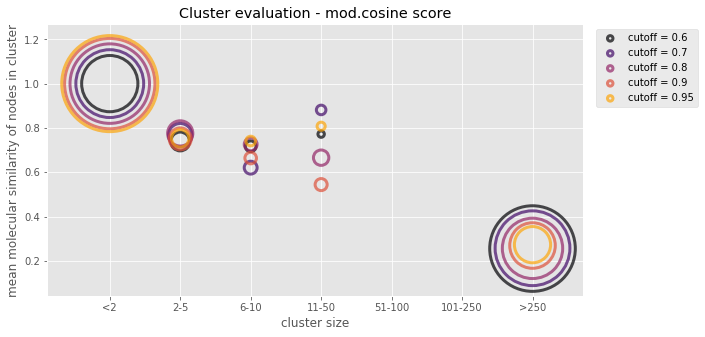

In [27]:
total_num_nodes = len(spectra)

size_bins = [1,5,10,50,100,250, len(spectra)]
labels_modcos = ['cutoff = ' + str(x) for x in thresholds]

plots_cluster_evaluations(DATA_modcos,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_modcos,
                              title = 'Cluster evaluation - mod.cosine score',
                              filename = 'modcos_min_match1_cluster_evaluation.pdf')

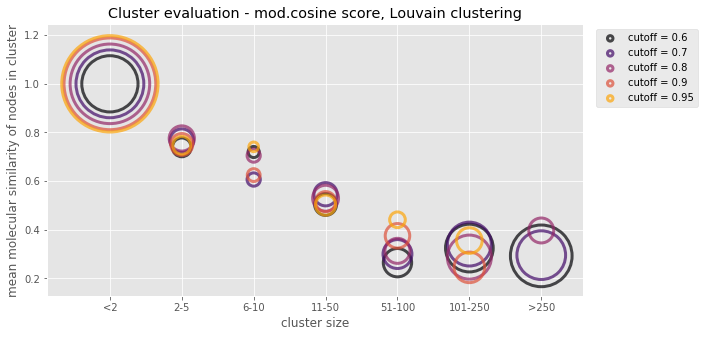

In [28]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_modcos = ['cutoff = ' + str(x) for x in thresholds]

plots_cluster_evaluations(DATA_modcos_louvain,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_modcos,
                              title = 'Cluster evaluation - mod.cosine score, Louvain clustering',
                              filename = 'modcos_min_match1_louvain_cluster_evaluation.pdf')

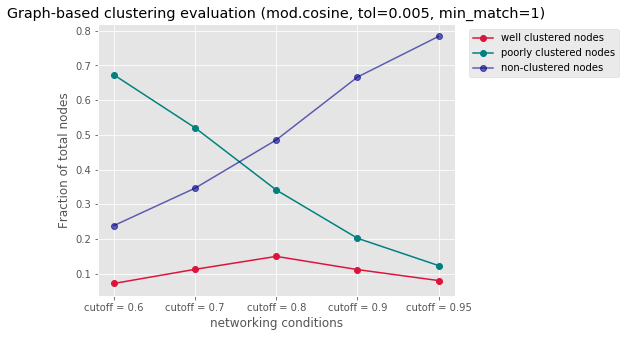

In [29]:
title = 'Graph-based clustering evaluation \n (mod.cosine, tol=0.005, min_match=1)'
plot_clustering_performance(DATA_modcos,
                            labels_modcos,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'modcos_min_match1_cluster_performance.pdf')

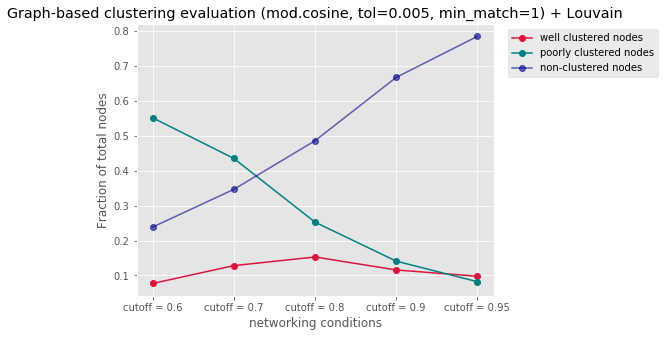

In [30]:
title = 'Graph-based clustering evaluation \n (mod.cosine, tol=0.005, min_match=1) + Louvain'
plot_clustering_performance(DATA_modcos_louvain,
                            labels_modcos,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'modcos_min_match1_louvain_cluster_performance.pdf')

## Modified cosine score networking (more optimal setting)
### tol = 0.005, min_match = 10

In [17]:
# Take mod.cosine scores and set scores to 0 for <10 matches
M_modcos = M_modcos_sim_greedy.copy()
M_modcos[np.where(M_modcos_matches_greedy < 10)] = 0

# Create numpy arrays to store top similarities for each spectrum
num_hits = 25
molnet_similars_idx = np.zeros((M_modcos.shape[0],num_hits), dtype=int)
molnet_similars = np.zeros((M_modcos.shape[0],num_hits))

for i in range(M_modcos.shape[0]):
    molnet_similars_idx[i,:] = M_modcos[i,:].argsort()[-num_hits:][::-1]
    molnet_similars[i,:] = M_modcos[i, molnet_similars_idx[i,:]]

### Create networks for different cutoffs

In [18]:
MSnets_modcos = []
DATA_modcos = []
DATA_modcos_louvain = []
thresholds = [0.6, 0.7, 0.8, 0.9, 0.95]

for thres in thresholds:
    MSnets_modcos.append(net.create_network(molnet_similars_idx,
                                           molnet_similars,
                                           max_links = 10,
                                           cutoff = thres,
                                           link_method = 'single'))
    
for network in MSnets_modcos:
    cluster_data = net.evaluate_clusters(network,
                                     M_sim_mol)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network,
                                                     M_sim_mol,
                                                     resolution = 1.0)
    
    DATA_modcos.append(cluster_data)
    DATA_modcos_louvain.append(cluster_data_louvain)

### Plot cluster sizes (for simple, unprocessed network)

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


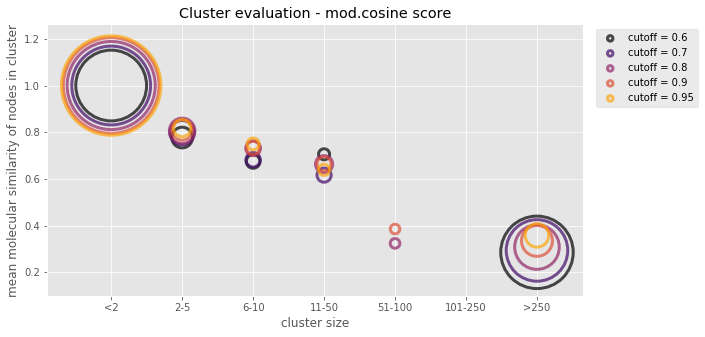

In [20]:
total_num_nodes = len(spectra)
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_modcos = ['cutoff = ' + str(x) for x in thresholds]

plots_cluster_evaluations(DATA_modcos,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_modcos,
                              title = 'Cluster evaluation - mod.cosine score',
                              filename = 'modcos_min_match10_cluster_evaluation.pdf')

### Plot cluster sizes (using Louvain algorithm)

C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


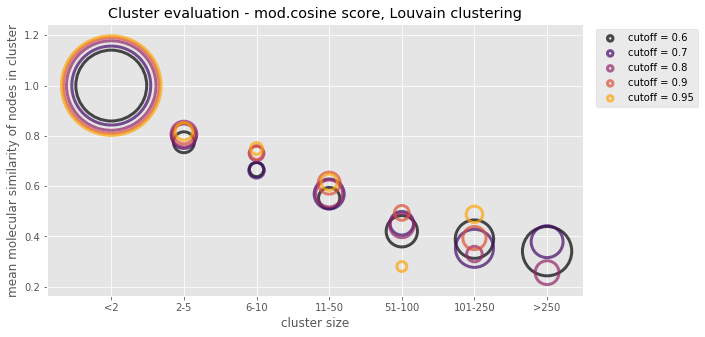

In [21]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_modcos = ['cutoff = ' + str(x) for x in thresholds]

plots_cluster_evaluations(DATA_modcos_louvain,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_modcos,
                              title = 'Cluster evaluation - mod.cosine score, Louvain clustering',
                              filename = 'modcos_min_match10_louvain_cluster_evaluation.pdf')

### Evalute quality of clusters
This is here done by classifying clusters with a average molecular similarity score <0.4 as poor. And clusters with a a mean molecular similariy > 0.6 as well clustered.

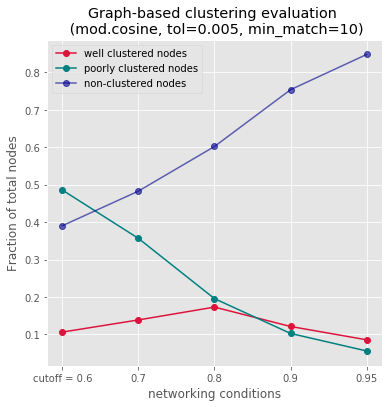

In [36]:
title = 'Graph-based clustering evaluation \n (mod.cosine, tol=0.005, min_match=10)'
plot_clustering_performance(DATA_modcos,
                            labels_modcos,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'modcos_min_match10_cluster_performance.pdf',
                            size_xy = (6,6))

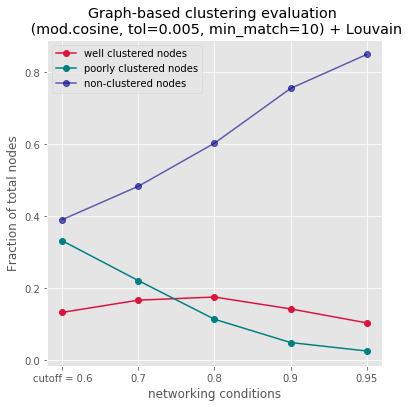

In [49]:
thresholds = [0.6, 0.7, 0.8, 0.9, 0.95]
title = 'Graph-based clustering evaluation \n (mod.cosine, tol=0.005, min_match=10) + Louvain'
labels_modcos = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_modcos_louvain,
                            labels_modcos,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'modcos_min_match10_louvain_cluster_performance.pdf',
                           size_xy = (6,6))

---
# 5. Create network from Spec2Vec similarities

### Create networks for different Spev2Vec similarity cutoffs

In [37]:
MSnets_s2v = []
DATA_s2v = []
DATA_s2v_louvain = []
thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for thres in thresholds:
    MSnets_s2v.append(net.create_network(MS_library.list_similars_ctr_idx,
                                           MS_library.list_similars_ctr,
                                           max_links = 10,
                                           cutoff = thres,
                                           link_method = 'single'))
    
for network in MSnets_s2v:
    cluster_data = net.evaluate_clusters(network,
                                     M_sim_mol)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network,
                                                     M_sim_mol,
                                                     resolution = 1.0)
    
    DATA_s2v.append(cluster_data)
    DATA_s2v_louvain.append(cluster_data_louvain)

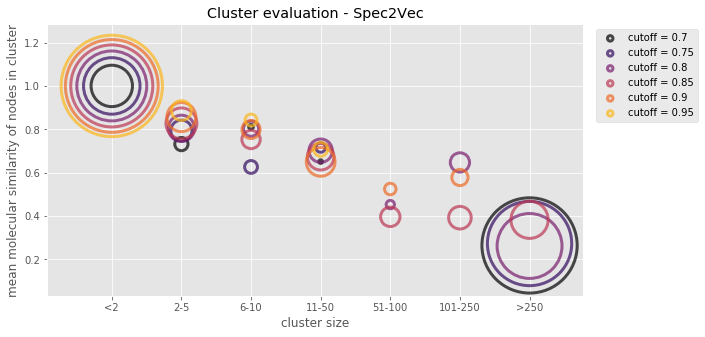

In [40]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_s2v = ['cutoff = ' + str(x) for x in thresholds]

plots_cluster_evaluations(DATA_s2v,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_s2v,
                              title = 'Cluster evaluation - Spec2Vec',
                              filename = 'S2V_cluster_evaluation.pdf')

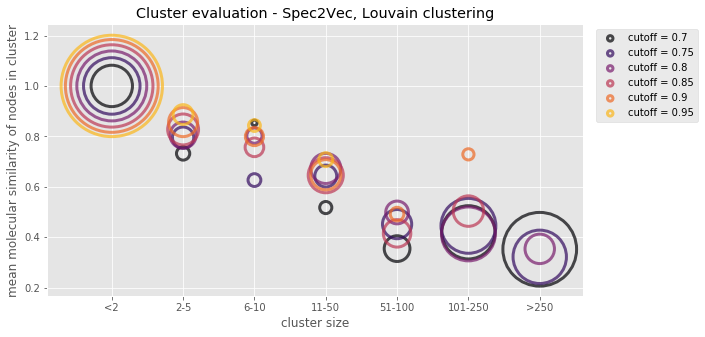

In [41]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_s2v = ['cutoff = ' + str(x) for x in thresholds]

plots_cluster_evaluations(DATA_s2v_louvain,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_s2v,
                              title = 'Cluster evaluation - Spec2Vec, Louvain clustering',
                              filename = 'S2V_louvain_cluster_evaluation.pdf')

#### Evalute quality of clusters
This is here done by classifying clusters with a average molecular similarity score <0.4 as poor. And clusters with a a mean molecular similariy > 0.6 as well clustered.

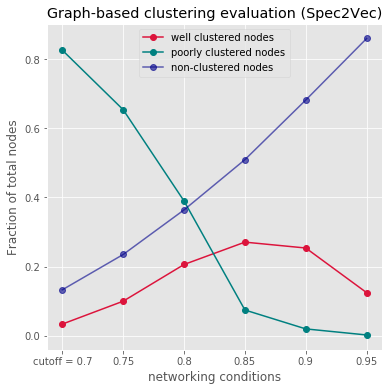

In [48]:
title = 'Graph-based clustering evaluation (Spec2Vec)'
labels_s2v = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_s2v,
                            labels_s2v,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_cluster_performance.pdf',
                            size_xy = (6,6))

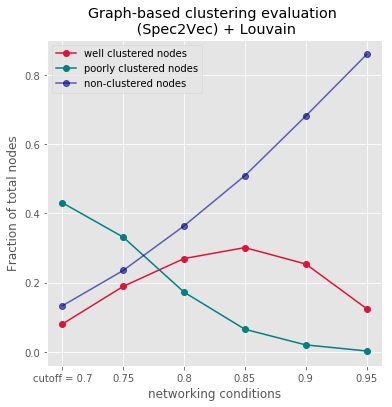

In [50]:
title = 'Graph-based clustering evaluation \n (Spec2Vec) + Louvain'
thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
labels_s2v = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_s2v_louvain,
                            labels_s2v,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_louvain_cluster_performance.pdf',
                            size_xy = (6,6))

# Make graph and export as graphml file

In [52]:
thres = 0.85

graph_s2v_085 = net.create_network(MS_library.list_similars_ctr_idx,
                                   MS_library.list_similars_ctr,
                                   max_links = 10,
                                   cutoff = thres,
                                   link_method = 'single')
    
graph_s2v_085_louvain, cluster_data_louvain = net.evaluate_clusters_louvain(graph_s2v_085,
                                                 M_sim_mol,
                                                 resolution = 1.0)

nx.write_graphml(graph_s2v_085_louvain, "graph_s2v_085_louvain.graphml")

In [55]:
cluster_data_louvain

,num_nodes,ref_sim_mean_nodes,ref_sim_var_nodes
0,1,1.000000,0.000000
1,41,0.429820,0.024991
2,2,0.838753,0.026000
3,1,1.000000,0.000000
4,53,0.583005,0.044459
...,...,...,...
6483,1,1.000000,0.000000
6484,1,1.000000,0.000000
6485,1,1.000000,0.000000
6486,1,1.000000,0.000000


In [54]:
# Add links by dilation step

graph_s2v_085_louvain_dil08, links_added = net.dilate_cluster(graph_s2v_085_louvain.copy(),
                                           MS_library.list_similars_ctr_idx,
                                           MS_library.list_similars_ctr,
                                           max_cluster_size = 90,   
                                           min_cluster_size = 10,
                                           max_per_cluster = None,
                                           min_weight = 0.8)

nx.write_graphml(graph_s2v_085_louvain_dil08, "graph_s2v_085_louvain_dil08.graphml")

# Direct comparison mod.cosine <-> spec2vec

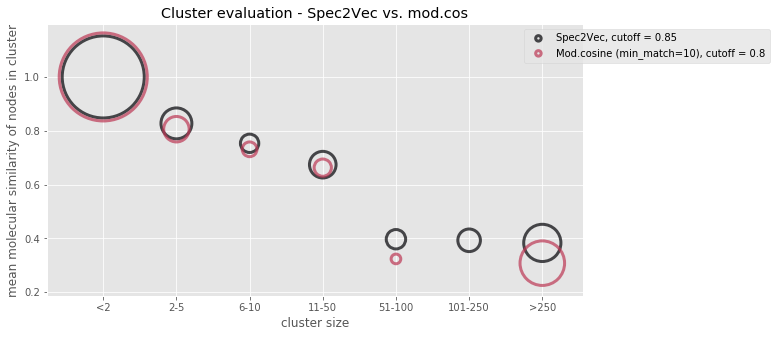

In [53]:
labels_compare = ['Spec2Vec, cutoff = 0.85','Mod.cosine (min_match=10), cutoff = 0.8']

plots_cluster_evaluations([DATA_s2v[3], DATA_modcos[2]],
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_compare,
                              title = 'Cluster evaluation - Spec2Vec vs. mod.cos',
                              filename = 'S2V_modcos_comparison_cluster_evaluation.pdf')


# Additional network trimming, filtering etc.

## Start with sparse network and add links ("dilation")
Here we start from a high cutoff (assuming this will mostly create reliable links).  
Then we run the **dilate_cluster()** function, which looks for possible additional links.  
The search will only consider nodes from small clusters (< min_cluster_size) and add the one highest link per node if it has a similarity/weight > min_weight.

In [ ]:
from networking import dilate_cluster

In [57]:
MSnet = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet_dil, links_added = dilate_cluster(MSnet.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 200,   
                           min_cluster_size = 10,
                           max_per_node = 1,
                           max_per_cluster = None,
                           min_weight = 0.85)

MSnet_dil2, links_added = dilate_cluster(MSnet_dil.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil3, links_added = dilate_cluster(MSnet_dil2.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil4, links_added = dilate_cluster(MSnet_dil3.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil5, links_added = dilate_cluster(MSnet_dil4.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 20,   
                           min_cluster_size = 4,
                           max_per_cluster = None,
                           min_weight = 0.7)

In [58]:
DATA_dilation = []
DATA_dilation_louvain = []

for network in [MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3, MSnet_dil4, MSnet_dil5]:
    cluster_data = net.evaluate_clusters(network,
                                     M_sim_mol)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network,
                                                     M_sim_mol,
                                                     resolution = 1.0)
    
    DATA_dilation.append(cluster_data)
    DATA_dilation_louvain.append(cluster_data_louvain)

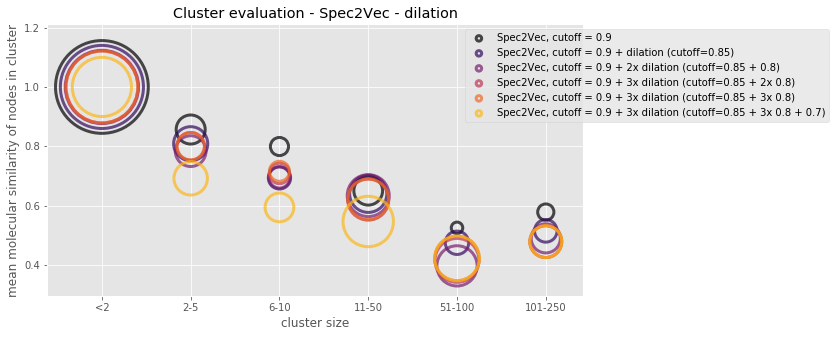

In [59]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_dilation = ['Spec2Vec, cutoff = 0.9',
                  'Spec2Vec, cutoff = 0.9 + dilation (cutoff=0.85)',
                 'Spec2Vec, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 2x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8 + 0.7)']

plots_cluster_evaluations(DATA_dilation,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - Spec2Vec - dilation',
                              filename = 'S2V_dilation_cluster_evaluation.pdf')

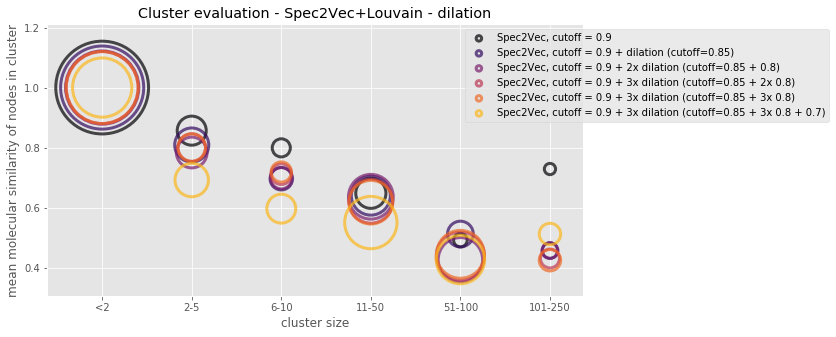

In [60]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_dilation = ['Spec2Vec, cutoff = 0.9',
                  'Spec2Vec, cutoff = 0.9 + dilation (cutoff=0.85)',
                 'Spec2Vec, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 2x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8 + 0.7)']

plots_cluster_evaluations(DATA_dilation_louvain,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - Spec2Vec+Louvain - dilation',
                              filename = 'S2V_louvain_dilation_cluster_evaluation.pdf')

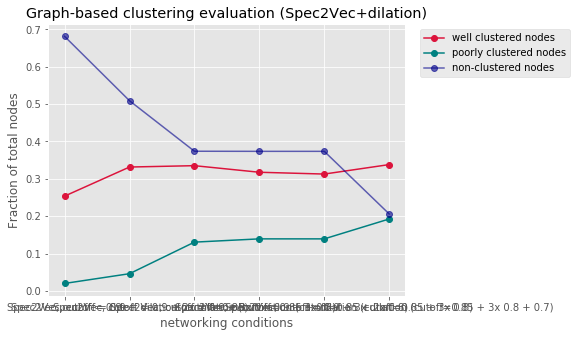

In [62]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation)'

plot_clustering_performance(DATA_dilation,
                            labels_dilation,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_cluster_performance.pdf')

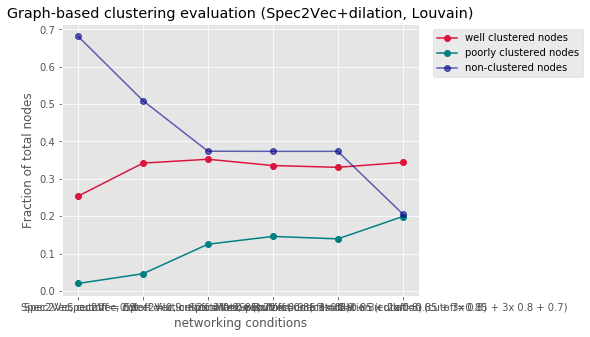

In [63]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation, Louvain)'

plot_clustering_performance(DATA_dilation_louvain,
                            labels_dilation,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_louvain_cluster_performance.pdf')

## Try dilation together with mod.cosine based networking
min_match=10, tol = 0.005

In [70]:
MSnet = net.create_network(molnet_similars_idx,
                           molnet_similars,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet_dil, links_added = dilate_cluster(MSnet.copy(),
                           molnet_similars_idx,
                           molnet_similars,
                           max_cluster_size = 200,   
                           min_cluster_size = 10,
                           max_per_node = 1,
                           max_per_cluster = None,
                           min_weight = 0.85)

MSnet_dil2, links_added = dilate_cluster(MSnet_dil.copy(),
                           molnet_similars_idx,
                           molnet_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil3, links_added = dilate_cluster(MSnet_dil2.copy(),
                           molnet_similars_idx,
                           molnet_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.75)

MSnet_dil4, links_added = dilate_cluster(MSnet_dil3.copy(),
                           molnet_similars_idx,
                           molnet_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.7)

MSnet_dil5, links_added = dilate_cluster(MSnet_dil4.copy(),
                           molnet_similars_idx,
                           molnet_similars,
                           max_cluster_size = 20,   
                           min_cluster_size = 4,
                           max_per_cluster = None,
                           min_weight = 0.65)

In [71]:
DATA_dilation = []
DATA_dilation_louvain = []

for network in [MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3, MSnet_dil4, MSnet_dil5]:
    cluster_data = net.evaluate_clusters(network,
                                     M_sim_mol)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network,
                                                     M_sim_mol,
                                                     resolution = 1.0)
    
    DATA_dilation.append(cluster_data)
    DATA_dilation_louvain.append(cluster_data_louvain)

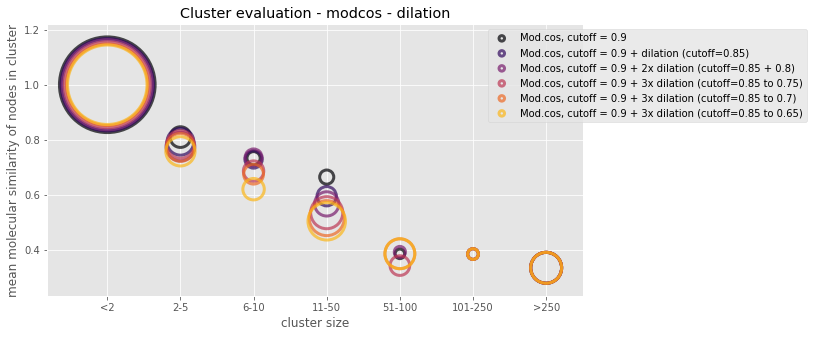

In [72]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_dilation = ['Mod.cos, cutoff = 0.9',
                  'Mod.cos, cutoff = 0.9 + dilation (cutoff=0.85)',
                 'Mod.cos, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                 'Mod.cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.75)',
                 'Mod.cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.7)',
                 'Mod.cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.65)']

plots_cluster_evaluations(DATA_dilation,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - modcos - dilation',
                              filename = 'modcos_dilation_cluster_evaluation.pdf')

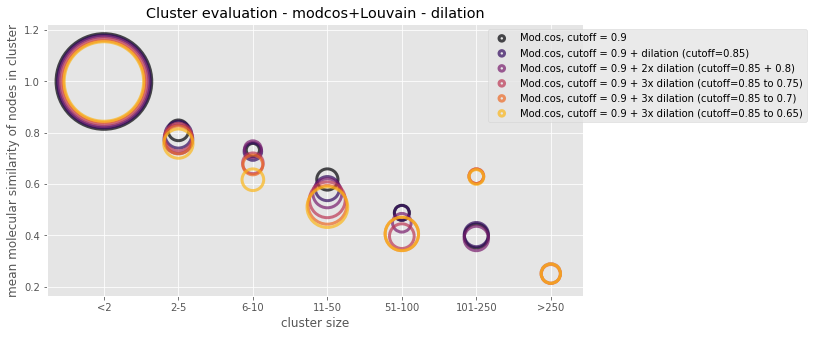

In [73]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_dilation = ['Mod.cos, cutoff = 0.9',
                  'Mod.cos, cutoff = 0.9 + dilation (cutoff=0.85)',
                 'Mod.cos, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                 'Mod.cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.75)',
                 'Mod.cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.7)',
                 'Mod.cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.65)']

plots_cluster_evaluations(DATA_dilation_louvain,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - modcos+Louvain - dilation',
                              filename = 'modcos_louvain_dilation_cluster_evaluation.pdf')

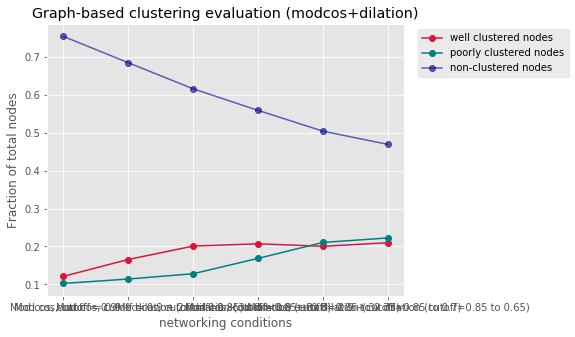

In [74]:
title = 'Graph-based clustering evaluation (modcos+dilation)'

plot_clustering_performance(DATA_dilation,
                            labels_dilation,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'modcos_dilation_cluster_performance.pdf')

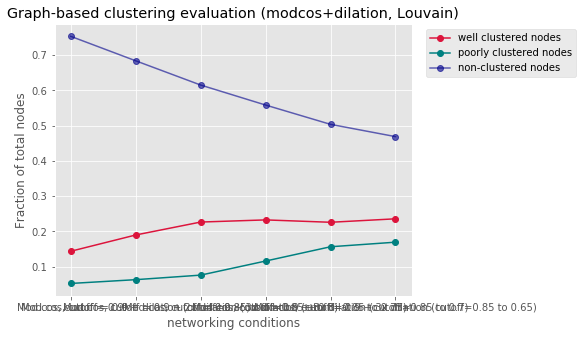

In [75]:
title = 'Graph-based clustering evaluation (modcos+dilation, Louvain)'

plot_clustering_performance(DATA_dilation_louvain,
                            labels_dilation,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'modcos_dilation_louvain_cluster_performance.pdf')

## Another test based on Spec2Vec

In [76]:
MSnet = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet_dil, links_added = dilate_cluster(MSnet.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 200,   
                           min_cluster_size = 10,
                           max_per_node = 1,
                           max_per_cluster = None,
                           min_weight = 0.85)

MSnet_dil2, links_added = dilate_cluster(MSnet.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.75)

MSnet_dil3, links_added = dilate_cluster(MSnet_dil.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.85)

MSnet_dil4, links_added = dilate_cluster(MSnet_dil.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil5, links_added = dilate_cluster(MSnet_dil.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 20,   
                           min_cluster_size = 4,
                           max_per_cluster = None,
                           min_weight = 0.7)

In [77]:
DATA_dilation = []
DATA_dilation_louvain = []

for network in [MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3, MSnet_dil4, MSnet_dil5]:
    cluster_data = net.evaluate_clusters(network,
                                     M_sim_mol)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network,
                                                     M_sim_mol,
                                                     resolution = 1.0)
    
    DATA_dilation.append(cluster_data)
    DATA_dilation_louvain.append(cluster_data_louvain)

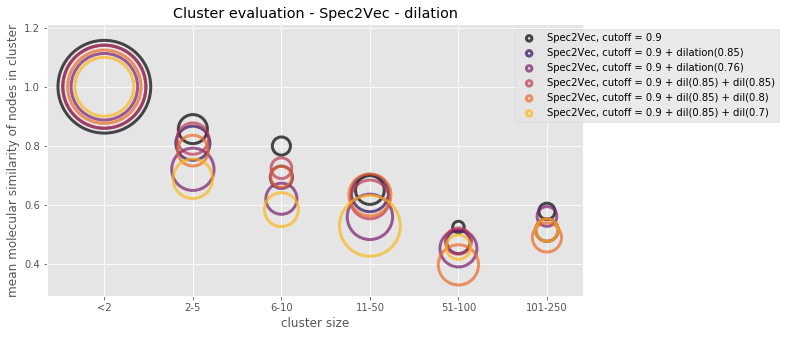

In [78]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_dilation = ['Spec2Vec, cutoff = 0.9',
                  'Spec2Vec, cutoff = 0.9 + dilation(0.85)',
                 'Spec2Vec, cutoff = 0.9 + dilation(0.76)',
                 'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.85)',
                 'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.8)',
                 'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.7)']

plots_cluster_evaluations(DATA_dilation,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - Spec2Vec - dilation',
                              filename = 'S2V_dilation_cluster_evaluation2.pdf')

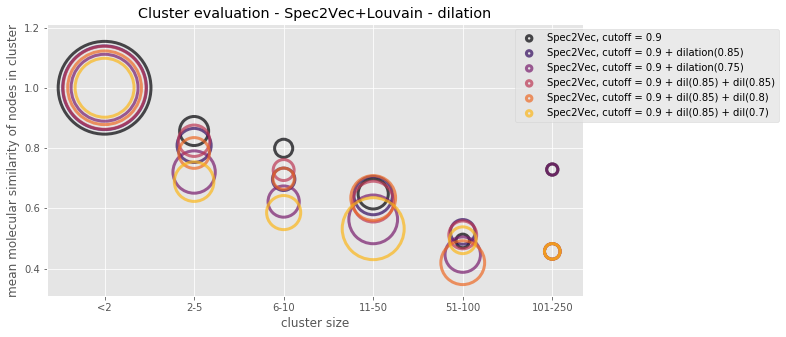

In [83]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_dilation = ['Spec2Vec, cutoff = 0.9',
                  'Spec2Vec, cutoff = 0.9 + dilation(0.85)',
                 'Spec2Vec, cutoff = 0.9 + dilation(0.75)',
                 'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.85)',
                 'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.8)',
                 'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.7)']

plots_cluster_evaluations(DATA_dilation_louvain,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - Spec2Vec+Louvain - dilation',
                              filename = 'S2V_louvain_dilation_cluster_evaluation2.pdf')

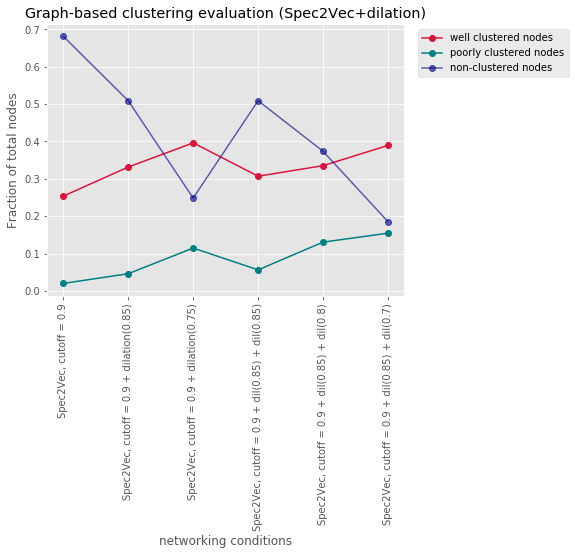

In [84]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation)'

plot_clustering_performance(DATA_dilation,
                            labels_dilation,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_cluster_performance2.pdf')
plt.xticks(labels_dilation, rotation='vertical')
plt.savefig('S2V_dilation_cluster_performance2.pdf', dpi=600)

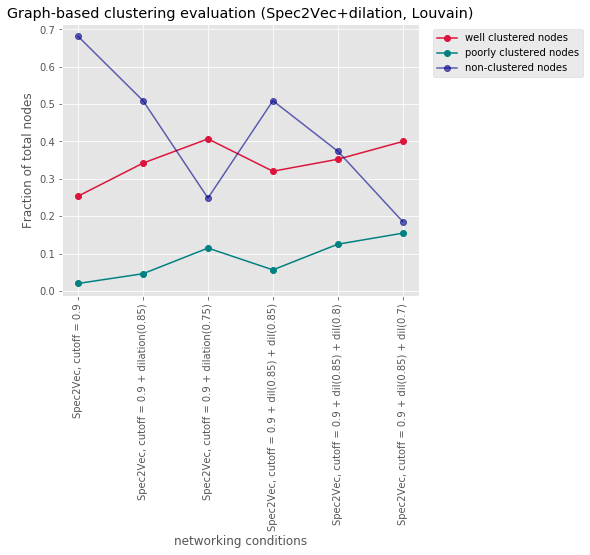

In [88]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation, Louvain)'

plot_clustering_performance(DATA_dilation_louvain,
                            labels_dilation,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_louvain_cluster_performance2.pdf')
plt.xticks(labels_dilation, rotation='vertical')
plt.savefig('S2V_dilation_louvain_cluster_performance2.pdf', dpi=600)

# Visualize what add_intra_cluster_links() function does:
Which essentially shows a bit that measures like density and transitivity (connectedness) are very sensitive to parameter choices!

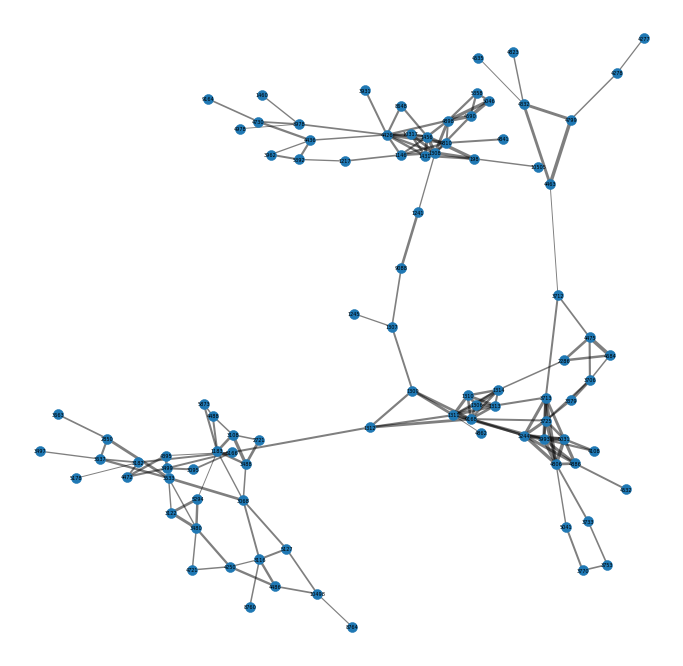

In [377]:
cm = plt.cm.get_cmap('gray')

G = graphs[167]
def plot_cluster(G):
    if len(G.nodes) > 1:
        edges = [(u, v) for (u, v, d) in G.edges(data=True) ]
        weights = [d['weight'] for (u, v, d) in G.edges(data=True) ]
        weights = weights - 0.95*np.min(weights)
        weights = weights/np.max(weights)

        pos = nx.spring_layout(G)  # positions for all nodes
        plt.figure(figsize=(12,12))
        # nodes
        nx.draw_networkx_nodes(G, pos, node_size=100)

        # edges
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=4*weights, alpha=0.5)

        # labels
        nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')

        plt.axis('off')
        plt.show()
        
plot_cluster(G)

In [394]:
MSnet_dil4_2 = net.add_intra_cluster_links(MSnet_dil4.copy(),
                           M_sim_mol, 
                           min_weight = 0.7)

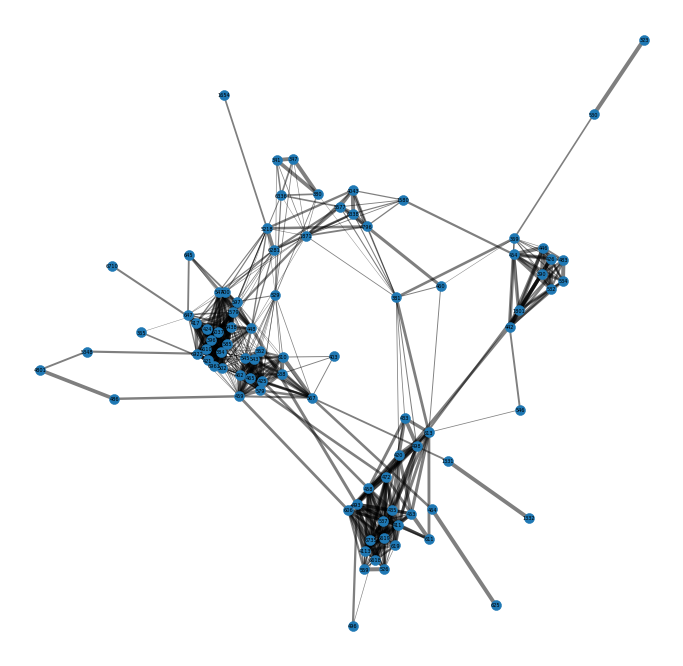

density: 0.14382022471910114
transitivity: 0.7207055858882823


In [396]:
G = graphs[selection[16]]
plot_cluster(graphs[selection[16]])
print('density:', nx.density(G))
print('transitivity:', nx.transitivity(G))

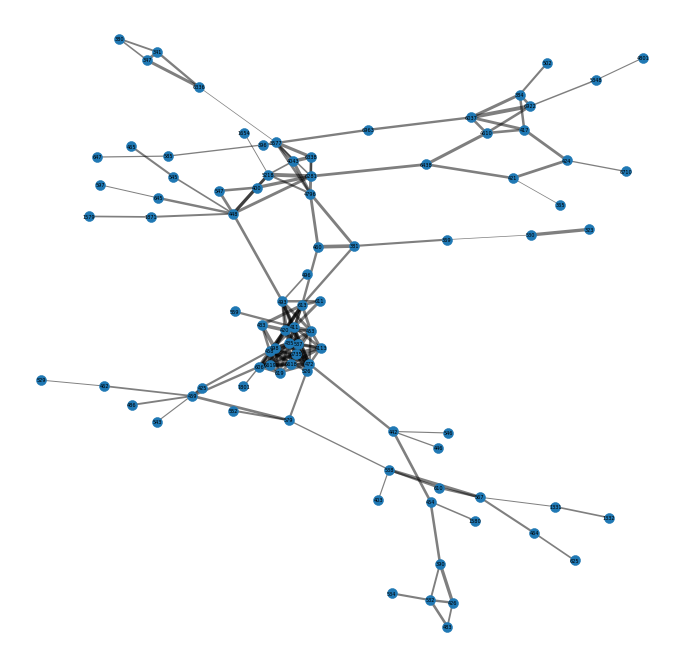

density: 0.04519350811485643
transitivity: 0.5152057245080501


In [386]:
G = graphs[selection[16]]
plot_cluster(graphs[selection[16]])
print('density:', nx.density(G))
print('transitivity:', nx.transitivity(G))

In [90]:
MSnet_dil2_added = net.add_intra_cluster_links(MSnet_dil2.copy(),
                                       M_sim_mol, 
                                       min_weight = 0.7)

In [91]:
cluster_data = net.evaluate_clusters(MSnet_dil2_added,
                                 M_sim_mol)

_, cluster_data_louvain = net.evaluate_clusters_louvain(MSnet_dil2_added,
                                                 M_sim_mol,
                                                 resolution = 1.0)

DATA_dilation.append(cluster_data)
DATA_dilation_louvain.append(cluster_data_louvain)

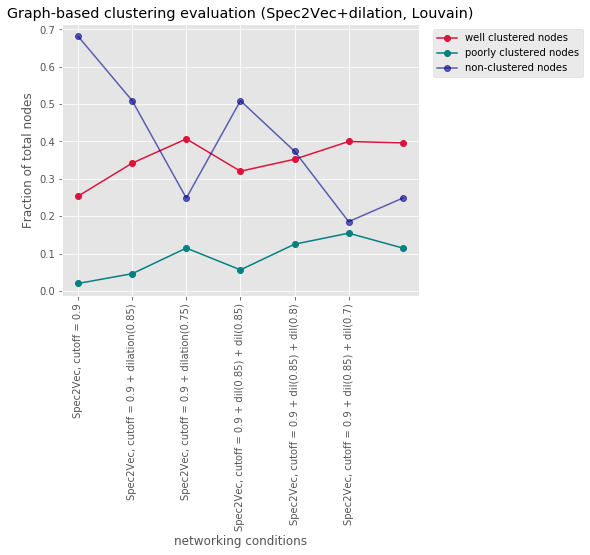

In [92]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation, Louvain)'

plot_clustering_performance(DATA_dilation_louvain,
                            labels_dilation + ['added links to dil(0.75)'],
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_louvain_cluster_performance2.pdf')
plt.xticks(labels_dilation, rotation='vertical')
plt.savefig('S2V_dilation_louvain_cluster_performance3.pdf', dpi=600)

# Some former tests and playing around...

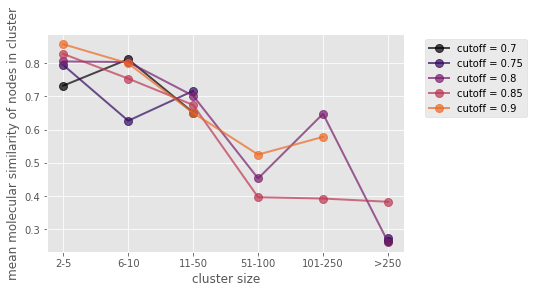

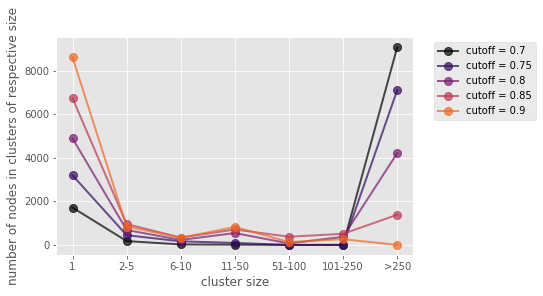

In [37]:


import matplotlib.colors as colors
import matplotlib.cm as cmx
cm = plt.get_cmap('inferno') #'jet' 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
for i, [num_elements, mean_edge_sim, mean_node_sim] in enumerate(plots):
    colorVal = scalarMap.to_rgba(i/(len(plots)+1))
    plt.plot(x_labels, mean_node_sim, 'o-', alpha= 0.7, lw=2, markersize=8, 
             color= colorVal, label=labels[i])
    plt.xlabel('cluster size')
    plt.ylabel('mean molecular similarity of nodes in cluster')   
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1))
for i in range(len(plots)):
    lgnd.legendHandles[i]._sizes = [30]

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
for i, [num_elements, mean_edge_sim, mean_node_sim] in enumerate(plots):
    colorVal = scalarMap.to_rgba(i/(len(plots)+1))
    plt.plot(x_labels, num_elements, 'o-', alpha= 0.7, lw=2, markersize=8, 
             color= colorVal, label=labels[i])
    plt.xlabel('cluster size')
    plt.ylabel('number of nodes in clusters of respective size')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1))
for i in range(len(plots)):
    lgnd.legendHandles[i]._sizes = [30]

In [50]:
cluster_data = evaluate_clusters(MSnet1,
                                     M_sim_mol)

In [51]:
cluster_data.head(10)

,num_nodes,num_edges,ref_sim_mean_edges,ref_sim_var_edges,ref_sim_mean_nodes,ref_sim_var_nodes
0,9074,43864,0.523674,0.077106,0.264760,0.018677
1,1,0,0.000000,0.000000,1.000000,0.000000
2,1,0,0.000000,0.000000,1.000000,0.000000
3,3,2,0.448009,0.068529,0.577687,0.128484
4,1,0,0.000000,0.000000,1.000000,0.000000
5,1,0,0.000000,0.000000,1.000000,0.000000
6,1,0,0.000000,0.000000,1.000000,0.000000
7,1,0,0.000000,0.000000,1.000000,0.000000
8,1,0,0.000000,0.000000,1.000000,0.000000
9,1,0,0.000000,0.000000,1.000000,0.000000


Text(0, 0.5, 'cluster size')

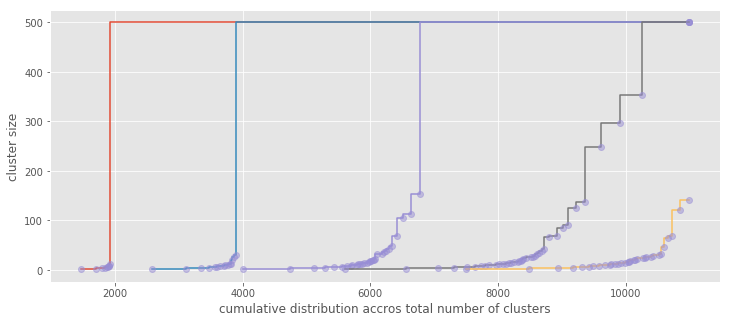

In [105]:
networks = [MSnet1, MSnet2, MSnet3, MSnet4, MSnet5]
y_max = 500
    
""" Run evaluation and series of plots.
"""
size_bins = [1,5,10,50,100,250, len(spectra)]
bins = [0] + [x+1 for x in size_bins]
x_labels = ['1', '2-5', '6-10', '11-50', '51-100', '101-250', '>250']
plt.style.use('ggplot')

data_collection = []
for network in networks:
    cluster_data = evaluate_clusters(network,
                                     M_sim_mol)
    
    data_collection.append(cluster_data)

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
for cluster_data in data_collection:    

    cum_dist = []
    cluster_sizes_unique = cluster_data.sort_values(by=('num_nodes'))['num_nodes'].unique()
    for cluster_size in cluster_sizes_unique:
        num_elements = cluster_size * np.sum(cluster_data['num_nodes'] == cluster_size)
        cum_dist.append((cluster_size, num_elements))
    y,x = np.array(list((zip(*cum_dist))))
    y[y>y_max] = y_max
    x_cum = [np.sum(x[:(i+1)]) for i in range(len(x))]
    plt.step(x_cum, y, where='pre', label='post')
    plt.plot(x_cum, y, 'C2o', alpha=0.5)    

plt.xlabel('cumulative distribution accros total number of clusters')
plt.ylabel('cluster size')